In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
movie_info_1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
movie_info_2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

In [ ]:
#Get familier with structure and data of movie_info_1
movie_info_1.columns

In [ ]:
#Get familier with structure and data of movie_info_2
movie_info_2.columns

In [ ]:
#Merge the both Dataframe
movie_data = movie_info_2.merge(movie_info_1,left_on='id', right_on='movie_id')
#Get the shape of the data
movie_data.shape

* So we have almost **24** columns with the record size of **4803** .Now Lets check the Sample of dat to understand it better

In [ ]:
movie_data.head(3)

* ## Language Wise Movie Distribution

In [ ]:
plt.figure(figsize=(10,5))
barplot_data = pd.DataFrame (movie_data['original_language'].value_counts() )
barplot_data.reset_index(inplace = True)
barplot_data.columns = ['language' , 'counts']
plt.bar( x = 'language' , height = 'counts' ,data = barplot_data.head(10))
plt.xlabel('Original Language')
plt.ylabel('Movies Counts') 
plt.title('Language-Wise Movie Distribution')
plt.show()

* As we see that , There is highly right tail skewed distribution .It mean we have very high numbers of Viewver who are only watching 'English' movie .

In [ ]:
#Movies popularity index wise histogram .
plt.figure(figsize=(10,5))
sns.distplot(movie_data['popularity'])

In [ ]:
#Check the status of the movie whether its release or not .
plt.figure(figsize=(10,5))
barplot_2 = pd.DataFrame (movie_data['status'].value_counts() )
barplot_2.reset_index(inplace = True)
barplot_2.columns = ['status' , 'counts']
plt.bar( x = 'status' , height = 'counts' ,data = barplot_2.head(10))
plt.xlabel('status')
plt.ylabel('Movies Counts') 
plt.title('Status-Wise Movie Distribution')
plt.show()

* Almost more than 95% of movies are are having  status is ** RELEASE ** and rest of movies are fall under different category like **Rummored ,  Post productction **

# **Content Based Filtering**
In this recommender system the content of the movie (overview) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

![](https://image.ibb.co/f6mDXU/conten.png)

## **Plot description based Recommender**

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the **overview** feature of our dataset. 
Let's take a look at the data. .. 

#### **Data Pre-processing Steps** :

* Basic Data Cleasing before going to Actual Implemention of Content Based Recommender Engine algorithm .
    1.	Lowercase
    2.	Number Removing 
    3.	Punctuations
    4.	White Spaces
    5.	Single Characters Handling
    6.	Null Value Handlings
    7.	Stop Words Treatments
    8.	Lemmatization
    10.	Tokenization
    12.	TF-IDF
    15.	Cosine similarity vs Cosine distance 
    16.	Different distance measure


In [ ]:
#Lowercasing the Dataframe column
movie_data['overview'] = movie_data['overview'].apply(lambda x:str(x).lower())

#Remove the Numbers from Overview columns
movie_data['overview'] = movie_data['overview'].apply(lambda x:re.sub(r"\d+", "", x))

#Remove all the Punctuation from the string 
movie_data['overview'] = movie_data['overview'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove the strings which are having lenght less than 3 
movie_data['overview'] = movie_data['overview'].apply(lambda x: re.sub(r'\b\w{1,3}\b', '', x))

#Replace NaN with an empty string
movie_data['overview'] = movie_data['overview'].fillna('')

#Remove all the mutliple space with singlular space
movie_data['overview'] = movie_data['overview'].apply(lambda x: re.sub('\s+', ' ', x).strip() )

In [ ]:
# import these modules 
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer() 

# a denotes adjective in "pos" 
movie_data['overview'] = movie_data['overview'].apply(lambda x: lemmatizer.lemmatize(x, pos ="a"))

In [ ]:
#Check the Sample After all data pre-processing is done
movie_data['overview'].head()

For any of you who has done even a  bit of text processing before knows we need to convert the word vector of each overview.
Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as
   **(term instances/total instances)**.
Inverse Document Frequency is the relative count of documents containing the term is given as 
**log(number of documents/documents with term)**
The overall importance of each word to the documents in which they appear is equal to **TF * IDF**

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each column represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it? 

In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movie_data['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

We see that over 22,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
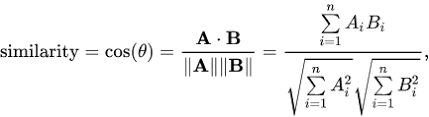

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movie_data.index, index=movie_data['title_x']).drop_duplicates()
indices.head()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movie_data['title_x'].iloc[movie_indices]

In [ ]:
get_recommendations('The Dark Knight Rises')

In [ ]:
#Do the Relality Check
pd.options.display.max_colwidth = 1000
movie_data.loc[movie_data['title_x']=='The Dark Knight Rises' , 'overview']

In [ ]:
movie_data.loc[movie_data['title_x']=='Batman Returns' , 'overview']

In [ ]:
get_recommendations('The Avengers')

In [ ]:
movie_data.loc[movie_data['title_x']=='The Avengers' , 'overview']

In [ ]:
movie_data.loc[movie_data['title_x']=='Avengers: Age of Ultron' , 'overview']

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.